In [11]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
from torchvision.datasets import GTSRB
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme


from torch.optim.lr_scheduler import StepLR

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 256 if torch.cuda.is_available() else 48
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 16 # Set to your device

import json
torch.set_float32_matmul_precision('medium')

In [5]:
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    transforms.Resize([224,224])
])

In [6]:
ds = torchvision.datasets.ImageFolder("img_data/",transform=data_transforms)

# Split the train set into training, validation and test
train_set, val_set = random_split(ds, [int(len(ds)*0.7), len(ds) - int(len(ds)*0.7)])
val_set, test_set = random_split(val_set, [int(len(val_set)*0.5), len(val_set) - int(len(val_set)*0.5)])

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers,persistent_workers=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers,persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [7]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [8]:
class FaceLandmarkDetection(pl.LightningModule):
    def __init__(self, learning_rate=0.003, num_classes=6):
        super().__init__()
        self.learning_rate = learning_rate 
        self.criterion = nn.CrossEntropyLoss()  ## Define your loss! What should it be?
        
        ## Load the pre-trained network as follows
        ## vit_b_16 from models
        ## Use the importedweights of:   ViT_B_16_Weights.IMAGENET1K_V1
        ## See pytorch documentation on how to load models with a pre-trained weight
        self.resnet = vit_b_16(weights=ViT_B_16_Weights)## Load the pre-trained network as follows
        ## Freeze vit_b_16 weights (see PDF's hints)
        ## You can set the param.requires_grad = False 
        ## That way those parameters will not get updated
        self.resnet.requires_grad_(False)

        ## Remake the vit_b_16 FC layer. You can use the in_features from the original model 
        self.resnet.heads.head = nn.Linear(768,num_classes)

        ## Which error do we use? Remember, we are dealing with minimising coordinate errors in the landmarks
        self.val_error = nn.CrossEntropyLoss()
        self.train_error = nn.CrossEntropyLoss()
        self.test_error = nn.CrossEntropyLoss()
        # Define your accuracies        
        self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            
    def forward(self, x):
        #Pass input through the model
        x_out = self.resnet(x)
    
        return x_out
    
    def training_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        acc = self.train_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        train_dict = {"train_loss": loss,
                    "train_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)
        acc = self.val_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        val_dict = {"val_loss": loss,
                    "val_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
    
        

    def test_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)
        acc = self.test_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        test_dict = {"test_loss": loss,
                    "test_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

        return preds, logits, x, y
    
    def predict_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        return preds, logits, x, y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

In [9]:
# Initialize the CNN model
max_epochs = 50 # Feel free to change this
model_cnn = FaceLandmarkDetection()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section/vit/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback],
    logger=CSVLogger(save_dir="logs_task/vit/"),
)

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\shelb/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [01:56<00:00, 2.96MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer_task.fit(model_cnn)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ criterion      │ CrossEntropyLoss   │      0 │
│ 1 │ resnet         │ VisionTransformer  │ 85.8 M │
│ 2 │ val_error      │ CrossEntropyLoss   │      0 │
│ 3 │ train_error    │ CrossEntropyLoss   │      0 │
│ 4 │ test_error     │ CrossEntropyLoss   │      0 │
│ 5 │ train_accuracy │ MulticlassAccuracy │      0 │
│ 6 │ val_accuracy   │ MulticlassAccuracy │      0 │
│ 7 │ test_accuracy  │ MulticlassAccuracy │      0 │
└───┴────────────────┴────────────────────┴────────┘

Trainable params: 4.6 K                                                                                            
Non-trainable params: 85.8 M                                                                                       
Total params: 85.8 M                                                                                               
Total estimated model params size (MB): 343

Output()

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\resul
t.py:212: UserWarning: You called `self.log('epoch', ...)` in your `training_step` but the value needs to be 
floating point. Converting it to torch.float32.
  warning_cache.warn(

Output()

Output()

In [132]:
# Concatenate the predictions from multiple batches
model_cnn.eval()
predictions = trainer_task.predict(model_cnn,test_loader)
test_maps = []
for pred_batch in predictions:
    for pred_map in pred_batch[4]:
        test_maps.append(pred_map)
test_outputs = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate model outputs
test_labels = torch.cat([prediction[3] for prediction in predictions], dim=0)  # Concatenate true labels
test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images
# Determine the predicted labels by selecting the class with the highest probability
test_preds = torch.cat([prediction[0] for prediction in predictions], dim=0)#test_outputs.argmax(dim=1)  # Find the index of the maximum probability along the classes (predicted labels)

Output()

['coordination_ring', 'asymmetric_advantages', 'cramped_room', 'coordination_ring', 'coordination_ring', 'random0', 'asymmetric_advantages', 'cramped_room', 'coordination_ring', 'cramped_room', 'coordination_ring', 'coordination_ring', 'cramped_room', 'coordination_ring', 'coordination_ring', 'coordination_ring', 'asymmetric_advantages', 'coordination_ring', 'random0', 'random3', 'asymmetric_advantages', 'coordination_ring', 'asymmetric_advantages', 'asymmetric_advantages', 'cramped_room', 'cramped_room', 'random3', 'coordination_ring', 'asymmetric_advantages', 'asymmetric_advantages', 'coordination_ring', 'coordination_ring', 'random3', 'coordination_ring', 'random0', 'coordination_ring', 'coordination_ring', 'random3', 'asymmetric_advantages', 'random3', 'coordination_ring', 'random0', 'coordination_ring', 'cramped_room', 'coordination_ring', 'random3', 'random3', 'asymmetric_advantages', 'random0', 'coordination_ring', 'cramped_room', 'random3', 'coordination_ring', 'coordination_ri

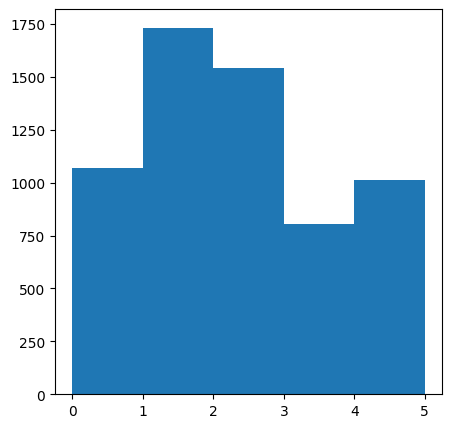

In [133]:
print(test_maps)
plt.hist(test_preds,bins=[0,1,2,3,4,5]);

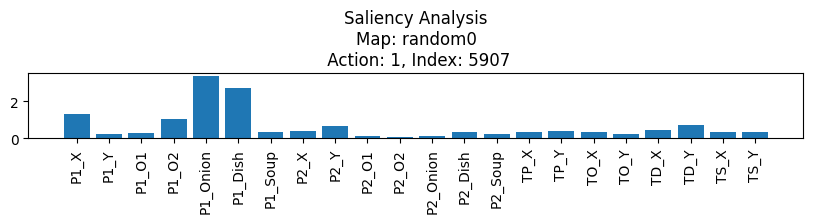

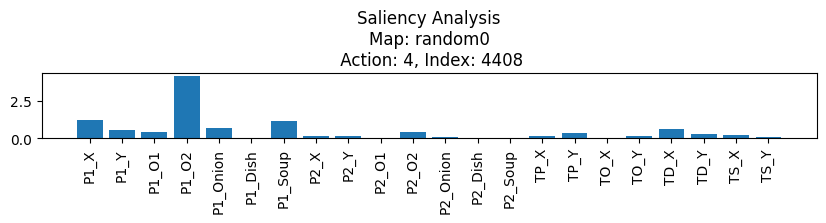

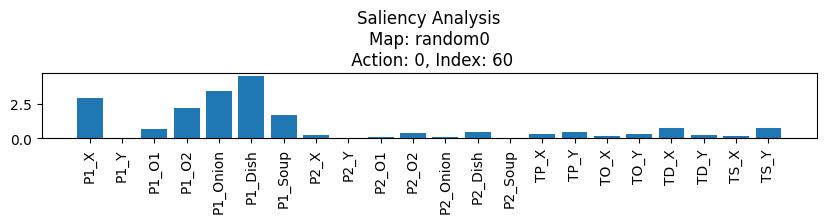

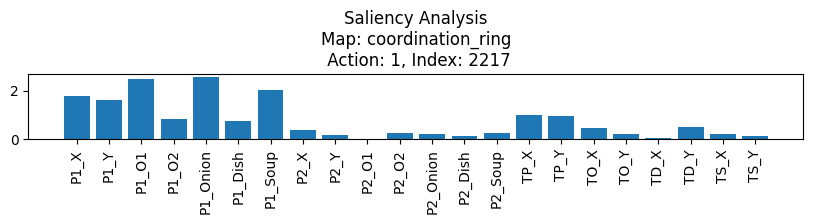

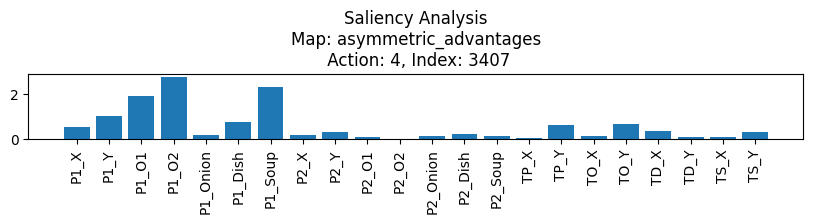

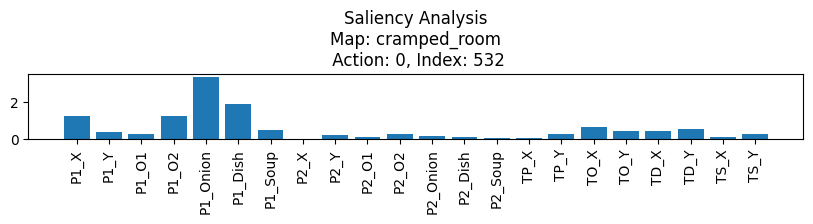

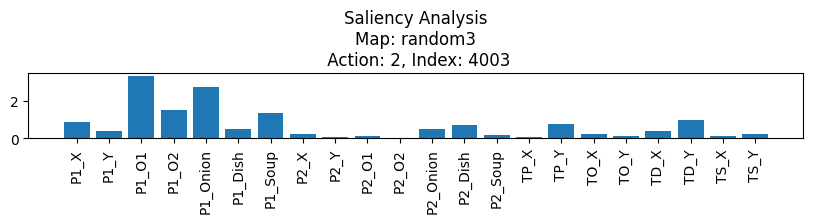

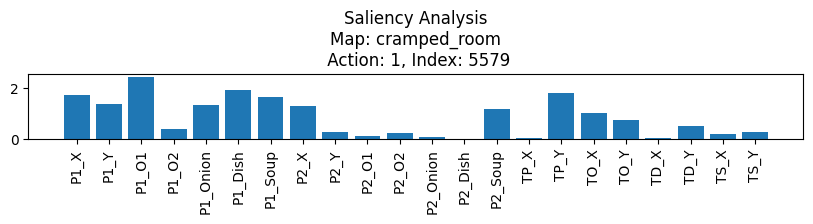

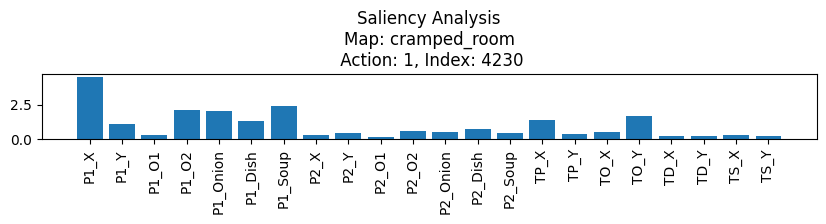

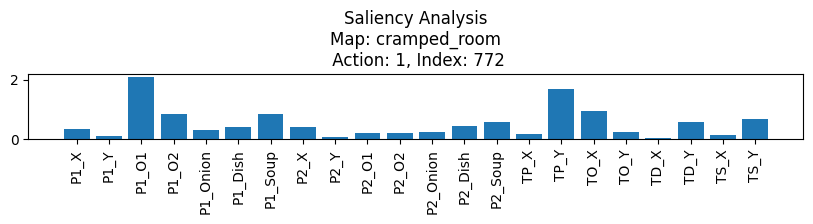

In [151]:
## Saliency map
# Find indices of correctly classified test samples
indices = torch.where(test_labels==test_preds)[0]

# Select a random index from the correctly classified samples
np.random.seed()#For consistent results
N=10
for n in range(N):
    rand_index=np.random.randint(0,len(indices))
    index = indices[rand_index].item()

    # Retrieve the input image, true label, model output, predicted label for the selected index
    pred = test_preds[index]
    label = test_labels[index]
    output = test_outputs[index]
    image_original = test_inputs[index]
    test_map = test_maps[index]

    # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
    image = image_original.unsqueeze(0)
    image.requires_grad = True

    # Compute the scores and gradients for the input image
    # To compute the scores, do a forward pass of the image and then take the argmax
    # Use this index to extract the score_max value from "scores"
    # Then perform a backward step so that it backpropagates the gradient
    scores = model_cnn.forward(image)
    score_max_index = torch.argmax(scores)
    score_max = scores[0, score_max_index]
    score_max.backward() # Do the backward step here for the gradient calculation

    # Calculate the saliency map by finding the maximum absolute gradient values across channels
    # You can use .abs() and torch.max()
    grad = image.grad
    grad_abs = torch.squeeze(grad.abs())

    # Create a subplot to display the original image and saliency map side by side
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.subplot(N,1,n+1)
    plt.bar(range(1,len(grad_abs)+1),grad_abs)
    plt.title(f"Saliency Analysis\nMap: {test_map}\n Action: {pred.item()}, Index: {index}")

    plt.xticks(ticks = range(1,len(grad_abs)+1),labels=label_list,rotation="vertical")
    # Show the original image and saliency map side by side
    plt.show()